# Temporal Pattern Deep Dive: Elliptic Bitcoin Dataset

**Objective:** Understand why temporal split performance (F1: 27.75%) is dramatically worse than random split (F1: 56.36%)

**Key Questions:**
1. What happens at time step 43 (dark market shutdown event)?
2. How do feature distributions shift over time?
3. Do fraud patterns evolve across 49 time steps?
4. Can we identify temporal inflection points where the model fails?
5. What time-aware features can improve robustness?

**Background:**
- 49 time steps (each ~2 weeks apart)
- Weber et al. (2019): All models failed after dark market shutdown at step 43
- Temporal split reflects real-world deployment: train on past, predict future

---
## Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import jensenshannon
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load data
classes_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
features_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv")
edgelist_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")

print(f"Classes: {classes_df.shape}")
print(f"Features: {features_df.shape}")
print(f"Edges: {edgelist_df.shape}")

Classes: (203769, 2)
Features: (203768, 167)
Edges: (234355, 2)


In [3]:
# Prepare data
node_ids = features_df.iloc[:, 0].values
time_steps = features_df.iloc[:, 1].values
X = features_df.iloc[:, 2:].values  # 166 features

# Map labels: '1'=illicit, '2'=licit
label_map = dict(zip(classes_df['txId'], classes_df['class']))
labels = np.array([label_map.get(nid, 'unknown') for nid in node_ids])

# Create DataFrame for easier analysis
df = pd.DataFrame({
    'node_id': node_ids,
    'time_step': time_steps,
    'label': labels
})

# Add feature columns
for i in range(X.shape[1]):
    df[f'feature_{i}'] = X[:, i]

print(f"\nDataset shape: {df.shape}")
print(f"Time step range: {time_steps.min()} to {time_steps.max()}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())


Dataset shape: (203768, 168)
Time step range: 1 to 49

Label distribution:
label
unknown    157204
2           42019
1            4545
Name: count, dtype: int64


---
## Part 1: Dark Market Shutdown Event (Time Step 43)

Weber et al. (2019) reported that all models failed after a dark market shutdown at time step 43. Let's investigate this critical event.

In [4]:
# Calculate transaction counts per time step by class
time_stats = df[df['label'] != 'unknown'].groupby(['time_step', 'label']).size().unstack(fill_value=0)
time_stats['total'] = time_stats.sum(axis=1)
time_stats['illicit_pct'] = time_stats['1'] / time_stats['total'] * 100

print("Transaction counts over time:")
print(time_stats.head(10))

Transaction counts over time:
label        1     2  total  illicit_pct
time_step                               
1           17  2130   2147     0.791803
2           18  1099   1117     1.611459
3           11  1268   1279     0.860047
4           30  1410   1440     2.083333
5            8  1874   1882     0.425080
6            5   480    485     1.030928
7          102  1101   1203     8.478803
8           67  1098   1165     5.751073
9          248   530    778    31.876607
10          18   954    972     1.851852


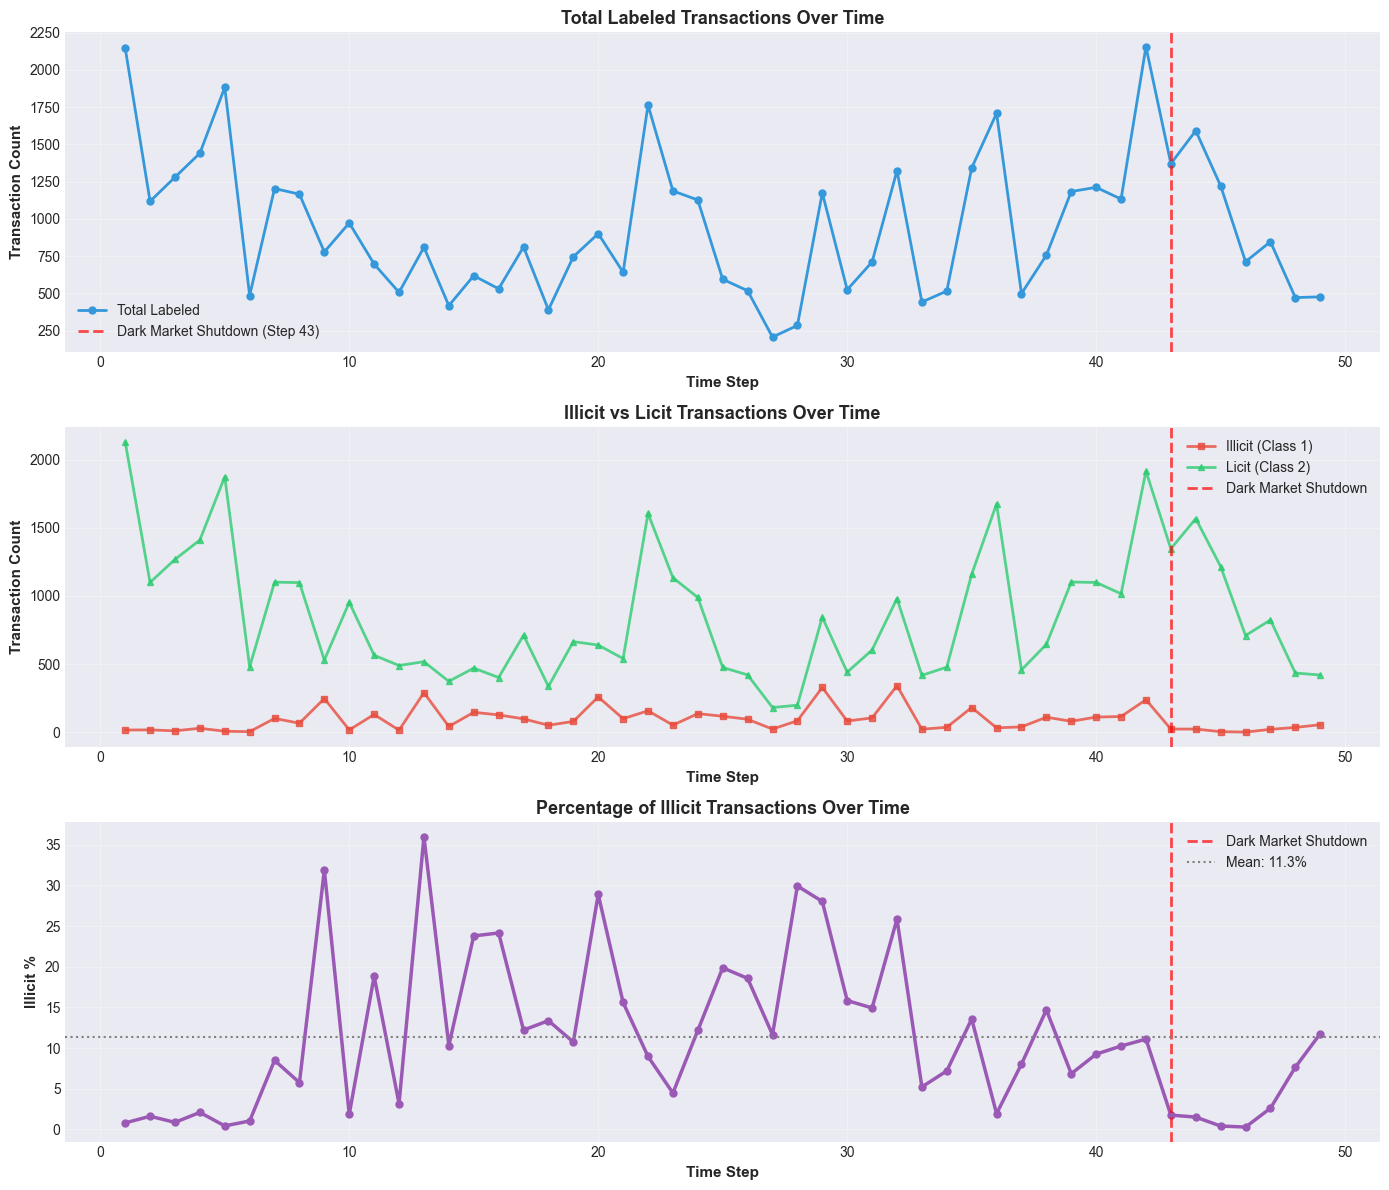

In [5]:
# Visualize transaction distribution over time
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Total transactions over time
ax = axes[0]
ax.plot(time_stats.index, time_stats['total'], marker='o', linewidth=2, 
        markersize=5, color='#3498db', label='Total Labeled')
ax.axvline(x=43, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label='Dark Market Shutdown (Step 43)')
ax.set_xlabel('Time Step', fontweight='bold', fontsize=11)
ax.set_ylabel('Transaction Count', fontweight='bold', fontsize=11)
ax.set_title('Total Labeled Transactions Over Time', fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Plot 2: Illicit vs Licit over time
ax = axes[1]
ax.plot(time_stats.index, time_stats['1'], marker='s', linewidth=2, 
        markersize=4, color='#e74c3c', label='Illicit (Class 1)', alpha=0.8)
ax.plot(time_stats.index, time_stats['2'], marker='^', linewidth=2, 
        markersize=4, color='#2ecc71', label='Licit (Class 2)', alpha=0.8)
ax.axvline(x=43, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label='Dark Market Shutdown')
ax.set_xlabel('Time Step', fontweight='bold', fontsize=11)
ax.set_ylabel('Transaction Count', fontweight='bold', fontsize=11)
ax.set_title('Illicit vs Licit Transactions Over Time', fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Plot 3: Illicit percentage over time
ax = axes[2]
ax.plot(time_stats.index, time_stats['illicit_pct'], marker='o', linewidth=2.5, 
        markersize=5, color='#9b59b6')
ax.axvline(x=43, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label='Dark Market Shutdown')
ax.axhline(y=time_stats['illicit_pct'].mean(), color='gray', linestyle=':', 
           linewidth=1.5, label=f'Mean: {time_stats["illicit_pct"].mean():.1f}%')
ax.set_xlabel('Time Step', fontweight='bold', fontsize=11)
ax.set_ylabel('Illicit %', fontweight='bold', fontsize=11)
ax.set_title('Percentage of Illicit Transactions Over Time', fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Quantify distribution shift before/after step 43
before_43 = time_stats[time_stats.index <= 43]
after_43 = time_stats[time_stats.index > 43]

print("Distribution Shift Analysis (Before vs After Step 43):")
print("="*60)
print(f"\nBefore Step 43 (Steps 1-43):")
print(f"  Avg illicit per step:  {before_43['1'].mean():.1f} (±{before_43['1'].std():.1f})")
print(f"  Avg licit per step:    {before_43['2'].mean():.1f} (±{before_43['2'].std():.1f})")
print(f"  Avg illicit %:         {before_43['illicit_pct'].mean():.2f}%")

print(f"\nAfter Step 43 (Steps 44-49):")
print(f"  Avg illicit per step:  {after_43['1'].mean():.1f} (±{after_43['1'].std():.1f})")
print(f"  Avg licit per step:    {after_43['2'].mean():.1f} (±{after_43['2'].std():.1f})")
print(f"  Avg illicit %:         {after_43['illicit_pct'].mean():.2f}%")

print(f"\nChange:")
illicit_change = (after_43['1'].mean() - before_43['1'].mean()) / before_43['1'].mean() * 100
licit_change = (after_43['2'].mean() - before_43['2'].mean()) / before_43['2'].mean() * 100
pct_change = after_43['illicit_pct'].mean() - before_43['illicit_pct'].mean()

print(f"  Illicit transactions:  {illicit_change:+.1f}%")
print(f"  Licit transactions:    {licit_change:+.1f}%")
print(f"  Illicit percentage:    {pct_change:+.2f} percentage points")
print("="*60)

Distribution Shift Analysis (Before vs After Step 43):

Before Step 43 (Steps 1-43):
  Avg illicit per step:  102.3 (±88.3)
  Avg licit per step:    856.9 (±485.4)
  Avg illicit %:         12.37%

After Step 43 (Steps 44-49):
  Avg illicit per step:  24.2 (±20.1)
  Avg licit per step:    862.0 (±452.7)
  Avg illicit %:         4.03%

Change:
  Illicit transactions:  -76.4%
  Licit transactions:    +0.6%
  Illicit percentage:    -8.33 percentage points


In [7]:
# Statistical test for distribution shift
stat, p_value = stats.mannwhitneyu(before_43['illicit_pct'], after_43['illicit_pct'], 
                                    alternative='two-sided')

print(f"\nMann-Whitney U Test (Illicit % Before vs After Step 43):")
print(f"  U-statistic: {stat:.2f}")
print(f"  P-value:     {p_value:.4f}")

if p_value < 0.05:
    print("  → Significant distribution shift detected! (p < 0.05)")
else:
    print("  → No significant shift detected (p >= 0.05)")


Mann-Whitney U Test (Illicit % Before vs After Step 43):
  U-statistic: 206.00
  P-value:     0.0167
  → Significant distribution shift detected! (p < 0.05)


---
## Part 2: Feature Distribution Shift Quantification

Using Kolmogorov-Smirnov test to identify which features have drifted between early (1-30) and late (31-49) periods.

In [8]:
# Split data into early and late periods
early_period = df[df['time_step'] <= 30]
late_period = df[df['time_step'] >= 31]

print(f"Early period (Steps 1-30): {len(early_period):,} transactions")
print(f"Late period (Steps 31-49): {len(late_period):,} transactions")

Early period (Steps 1-30): 123,286 transactions
Late period (Steps 31-49): 80,482 transactions


In [9]:
# Conduct KS test for all 166 features
print("Conducting Kolmogorov-Smirnov tests for feature drift...\n")

drift_results = []
feature_cols = [f'feature_{i}' for i in range(165)]

for i, feat in enumerate(feature_cols):
    early_vals = early_period[feat].values
    late_vals = late_period[feat].values
    
    # KS test
    ks_stat, ks_p = ks_2samp(early_vals, late_vals)
    
    # Jensen-Shannon divergence (for probability distributions)
    # Create histograms
    bins = np.linspace(min(early_vals.min(), late_vals.min()), 
                       max(early_vals.max(), late_vals.max()), 50)
    early_hist, _ = np.histogram(early_vals, bins=bins, density=True)
    late_hist, _ = np.histogram(late_vals, bins=bins, density=True)
    
    # Normalize to probability distributions
    early_hist = early_hist / early_hist.sum() if early_hist.sum() > 0 else early_hist
    late_hist = late_hist / late_hist.sum() if late_hist.sum() > 0 else late_hist
    
    # Add small epsilon to avoid division by zero
    early_hist = early_hist + 1e-10
    late_hist = late_hist + 1e-10
    
    js_div = jensenshannon(early_hist, late_hist)
    
    drift_results.append({
        'Feature_Index': i,
        'Feature_Name': feat,
        'Feature_Type': 'Local' if i < 94 else 'Aggregated',
        'KS_Statistic': ks_stat,
        'KS_P_Value': ks_p,
        'JS_Divergence': js_div,
        'Early_Mean': early_vals.mean(),
        'Late_Mean': late_vals.mean(),
        'Mean_Shift': late_vals.mean() - early_vals.mean()
    })

drift_df = pd.DataFrame(drift_results)
print("✓ Feature drift analysis complete!")

Conducting Kolmogorov-Smirnov tests for feature drift...

✓ Feature drift analysis complete!


In [10]:
# Identify features with significant drift
significant_drift = drift_df[drift_df['KS_P_Value'] < 0.001]
n_drifted = len(significant_drift)

print(f"Features with Significant Drift (p < 0.001): {n_drifted} / 166 ({n_drifted/166*100:.1f}%)")
print(f"\nBreakdown by type:")
print(significant_drift['Feature_Type'].value_counts())

print(f"\nTop 20 Features with Strongest Drift (by KS statistic):")
top_drift = drift_df.nsmallest(20, 'KS_P_Value')
print(top_drift[['Feature_Index', 'Feature_Type', 'KS_Statistic', 'KS_P_Value', 
                  'JS_Divergence', 'Mean_Shift']].to_string(index=False))

Features with Significant Drift (p < 0.001): 160 / 166 (96.4%)

Breakdown by type:
Feature_Type
Local         93
Aggregated    67
Name: count, dtype: int64

Top 20 Features with Strongest Drift (by KS statistic):
 Feature_Index Feature_Type  KS_Statistic  KS_P_Value  JS_Divergence  Mean_Shift
             0        Local      0.092139         0.0       0.049054   -0.061474
             1        Local      0.639726         0.0       0.088964    0.325586
             2        Local      0.510060         0.0       0.427975    1.047253
             8        Local      0.092715         0.0       0.048241   -0.061322
            16        Local      0.093717         0.0       0.048861   -0.063128
            18        Local      0.089819         0.0       0.056136   -0.090826
            21        Local      0.100462         0.0       0.086227   -0.027290
            22        Local      0.120938         0.0       0.100554   -0.098584
            24        Local      0.116703         0.0     

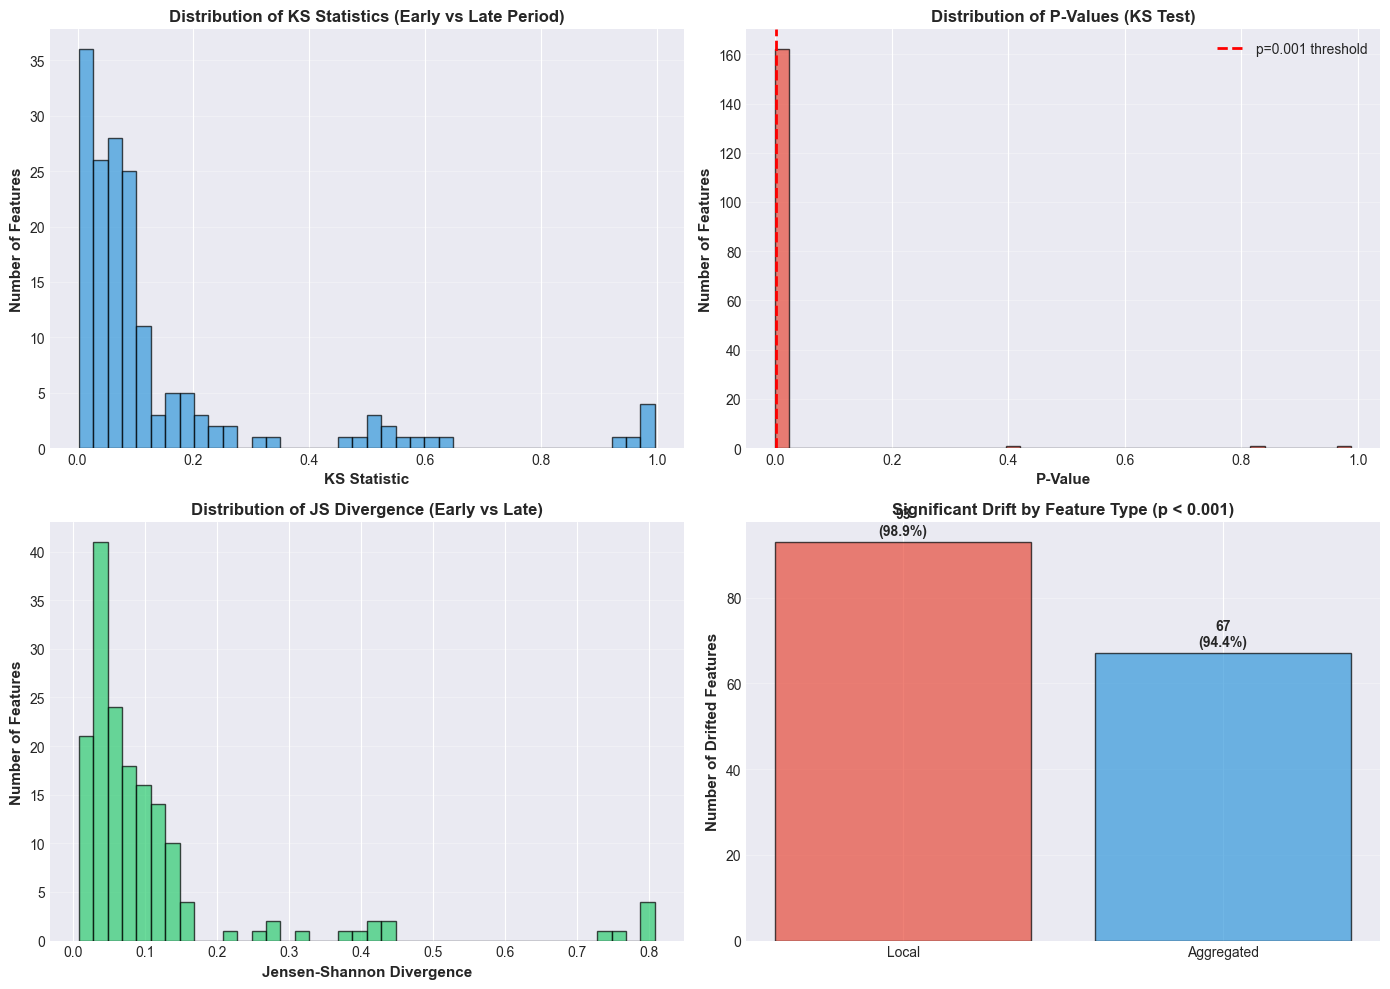

In [11]:
# Visualize feature drift
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: KS statistic distribution
ax = axes[0, 0]
ax.hist(drift_df['KS_Statistic'], bins=40, edgecolor='black', alpha=0.7, color='#3498db')
ax.set_xlabel('KS Statistic', fontweight='bold', fontsize=11)
ax.set_ylabel('Number of Features', fontweight='bold', fontsize=11)
ax.set_title('Distribution of KS Statistics (Early vs Late Period)', fontweight='bold', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Plot 2: P-value distribution
ax = axes[0, 1]
ax.hist(drift_df['KS_P_Value'], bins=40, edgecolor='black', alpha=0.7, color='#e74c3c')
ax.axvline(x=0.001, color='red', linestyle='--', linewidth=2, label='p=0.001 threshold')
ax.set_xlabel('P-Value', fontweight='bold', fontsize=11)
ax.set_ylabel('Number of Features', fontweight='bold', fontsize=11)
ax.set_title('Distribution of P-Values (KS Test)', fontweight='bold', fontsize=12)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Plot 3: Jensen-Shannon divergence
ax = axes[1, 0]
ax.hist(drift_df['JS_Divergence'], bins=40, edgecolor='black', alpha=0.7, color='#2ecc71')
ax.set_xlabel('Jensen-Shannon Divergence', fontweight='bold', fontsize=11)
ax.set_ylabel('Number of Features', fontweight='bold', fontsize=11)
ax.set_title('Distribution of JS Divergence (Early vs Late)', fontweight='bold', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Plot 4: Drift by feature type
ax = axes[1, 1]
drift_by_type = drift_df[drift_df['KS_P_Value'] < 0.001]['Feature_Type'].value_counts()
total_by_type = drift_df['Feature_Type'].value_counts()
drift_pct = (drift_by_type / total_by_type * 100)

bars = ax.bar(drift_by_type.index, drift_by_type.values, 
              color=['#e74c3c', '#3498db'], alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Drifted Features', fontweight='bold', fontsize=11)
ax.set_title('Significant Drift by Feature Type (p < 0.001)', fontweight='bold', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (bar, pct_val) in enumerate(zip(bars, drift_pct)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{int(height)}\n({pct_val:.1f}%)', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

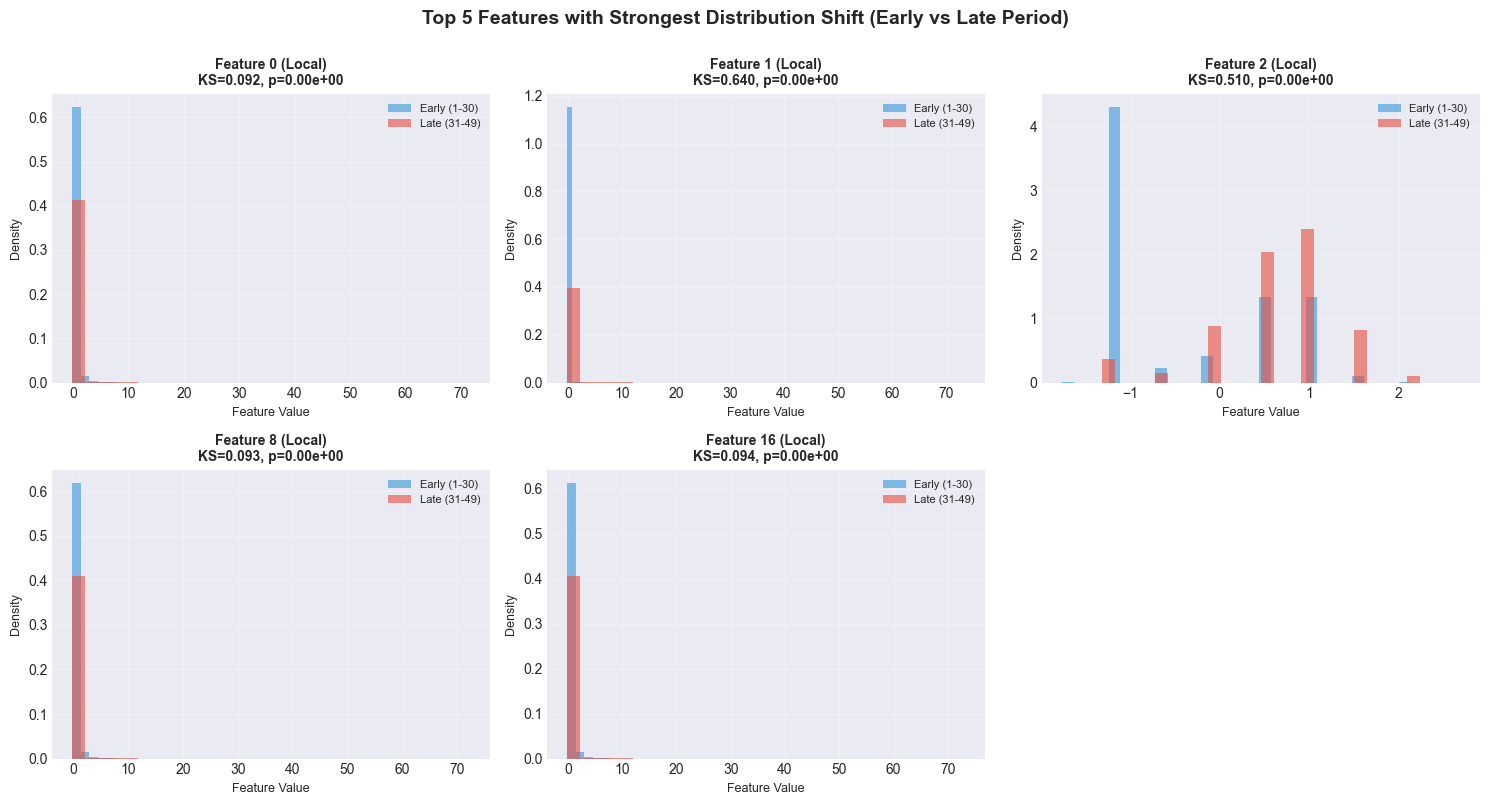

In [12]:
# Visualize distribution shift for top drifted features
top_5_drift = drift_df.nsmallest(5, 'KS_P_Value')

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, (_, row) in enumerate(top_5_drift.iterrows()):
    if idx >= 6:
        break
        
    ax = axes[idx]
    feat_name = row['Feature_Name']
    
    early_vals = early_period[feat_name].values
    late_vals = late_period[feat_name].values
    
    ax.hist(early_vals, bins=30, alpha=0.6, color='#3498db', label='Early (1-30)', density=True)
    ax.hist(late_vals, bins=30, alpha=0.6, color='#e74c3c', label='Late (31-49)', density=True)
    
    ax.set_xlabel('Feature Value', fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.set_title(f'Feature {row["Feature_Index"]} ({row["Feature_Type"]})\n' + 
                 f'KS={row["KS_Statistic"]:.3f}, p={row["KS_P_Value"]:.2e}', 
                 fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

# Remove extra subplot
if len(top_5_drift) < 6:
    fig.delaxes(axes[5])

fig.suptitle('Top 5 Features with Strongest Distribution Shift (Early vs Late Period)', 
             fontweight='bold', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

---
## Part 3: Fraud Pattern Evolution Over Time

Analyze how fraud signatures change across the 49 time steps.

In [13]:
# Extract fraud signatures (mean feature vector) per time step
print("Extracting fraud signatures for each time step...\n")

fraud_signatures = []
licit_signatures = []

for ts in range(1, 50):
    ts_data = df[df['time_step'] == ts]
    
    # Fraud signature
    fraud_data = ts_data[ts_data['label'] == '1']
    if len(fraud_data) > 0:
        fraud_sig = fraud_data[feature_cols].mean().values
        fraud_signatures.append(fraud_sig)
    else:
        fraud_signatures.append(None)
    
    # Licit signature
    licit_data = ts_data[ts_data['label'] == '2']
    if len(licit_data) > 0:
        licit_sig = licit_data[feature_cols].mean().values
        licit_signatures.append(licit_sig)
    else:
        licit_signatures.append(None)

print(f"Extracted signatures for {sum(s is not None for s in fraud_signatures)} time steps (fraud)")
print(f"Extracted signatures for {sum(s is not None for s in licit_signatures)} time steps (licit)")

Extracting fraud signatures for each time step...

Extracted signatures for 49 time steps (fraud)
Extracted signatures for 49 time steps (licit)


In [14]:
# Calculate cosine similarity between consecutive time steps
from sklearn.metrics.pairwise import cosine_similarity

fraud_similarities = []
licit_similarities = []

for i in range(len(fraud_signatures) - 1):
    # Fraud similarity
    if fraud_signatures[i] is not None and fraud_signatures[i+1] is not None:
        sim = cosine_similarity([fraud_signatures[i]], [fraud_signatures[i+1]])[0][0]
        fraud_similarities.append(sim)
    else:
        fraud_similarities.append(np.nan)
    
    # Licit similarity
    if licit_signatures[i] is not None and licit_signatures[i+1] is not None:
        sim = cosine_similarity([licit_signatures[i]], [licit_signatures[i+1]])[0][0]
        licit_similarities.append(sim)
    else:
        licit_similarities.append(np.nan)

print("Cosine similarity between consecutive time steps calculated!")

Cosine similarity between consecutive time steps calculated!


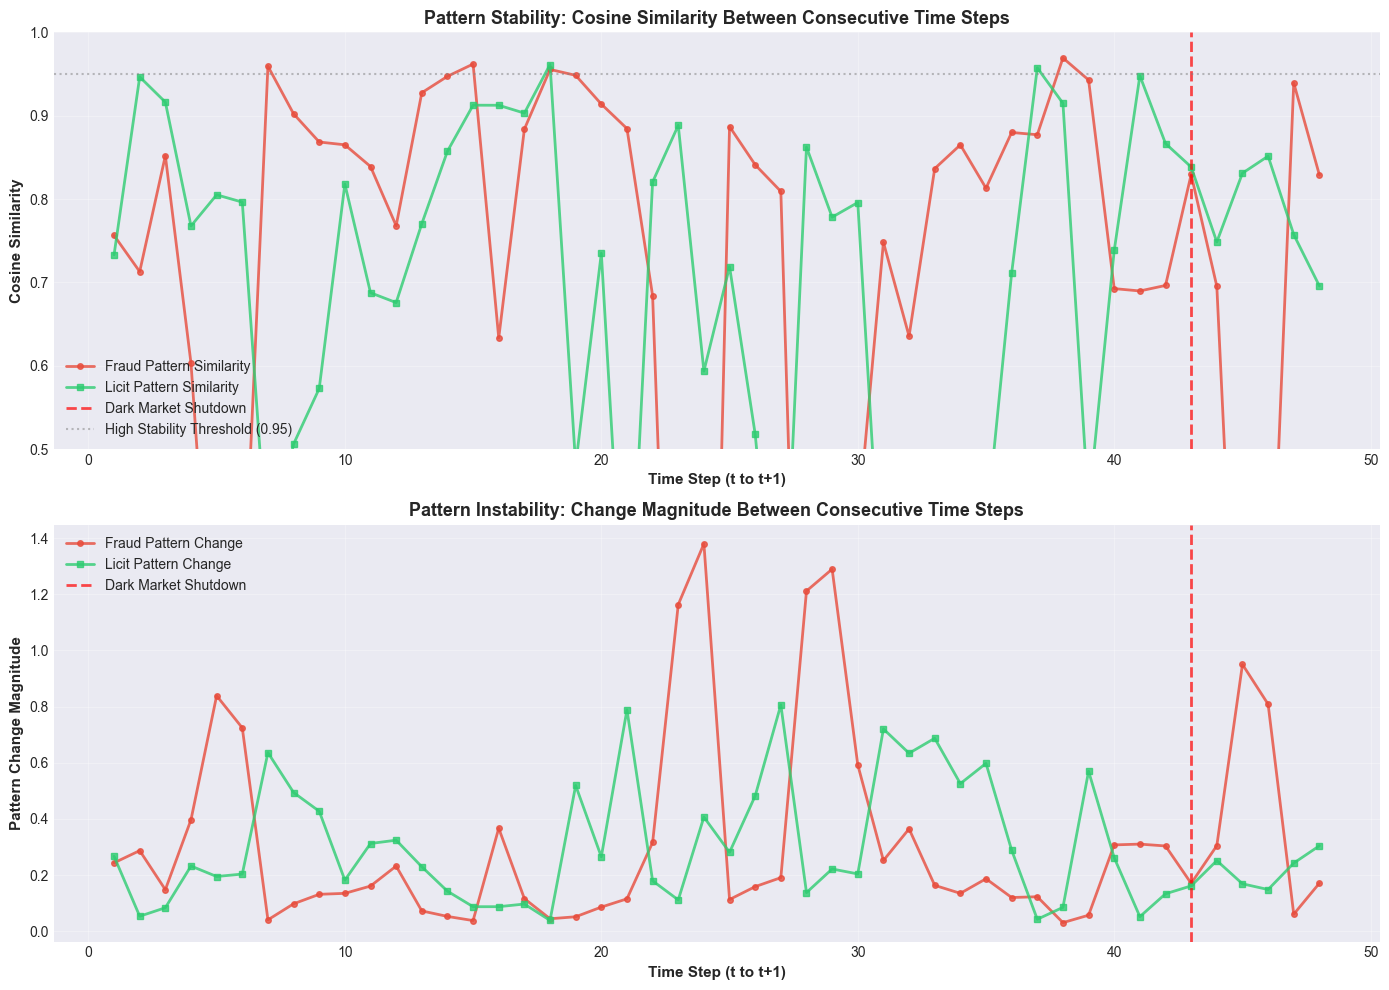

In [15]:
# Visualize fraud pattern evolution
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Cosine similarity between consecutive time steps
ax = axes[0]
time_steps_plot = list(range(1, 49))

ax.plot(time_steps_plot, fraud_similarities, marker='o', linewidth=2, 
        markersize=4, color='#e74c3c', label='Fraud Pattern Similarity', alpha=0.8)
ax.plot(time_steps_plot, licit_similarities, marker='s', linewidth=2, 
        markersize=4, color='#2ecc71', label='Licit Pattern Similarity', alpha=0.8)

ax.axvline(x=43, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label='Dark Market Shutdown')
ax.axhline(y=0.95, color='gray', linestyle=':', linewidth=1.5, alpha=0.5, 
           label='High Stability Threshold (0.95)')

ax.set_xlabel('Time Step (t to t+1)', fontweight='bold', fontsize=11)
ax.set_ylabel('Cosine Similarity', fontweight='bold', fontsize=11)
ax.set_title('Pattern Stability: Cosine Similarity Between Consecutive Time Steps', 
             fontweight='bold', fontsize=13)
ax.legend(fontsize=10, loc='lower left')
ax.grid(alpha=0.3)
ax.set_ylim([0.5, 1.0])

# Plot 2: Pattern change magnitude (1 - similarity)
ax = axes[1]
fraud_pattern_change = [1 - s if not np.isnan(s) else np.nan for s in fraud_similarities]
licit_pattern_change = [1 - s if not np.isnan(s) else np.nan for s in licit_similarities]

ax.plot(time_steps_plot, fraud_pattern_change, marker='o', linewidth=2, 
        markersize=4, color='#e74c3c', label='Fraud Pattern Change', alpha=0.8)
ax.plot(time_steps_plot, licit_pattern_change, marker='s', linewidth=2, 
        markersize=4, color='#2ecc71', label='Licit Pattern Change', alpha=0.8)

ax.axvline(x=43, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label='Dark Market Shutdown')

ax.set_xlabel('Time Step (t to t+1)', fontweight='bold', fontsize=11)
ax.set_ylabel('Pattern Change Magnitude', fontweight='bold', fontsize=11)
ax.set_title('Pattern Instability: Change Magnitude Between Consecutive Time Steps', 
             fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Identify significant pattern changes
threshold = 0.90  # Similarity below this indicates significant change

fraud_changes = [(i+1, 1-fraud_similarities[i]) 
                 for i in range(len(fraud_similarities)) 
                 if not np.isnan(fraud_similarities[i]) and fraud_similarities[i] < threshold]

print(f"Time Steps with Significant Fraud Pattern Changes (similarity < {threshold}):")
print("="*60)
for ts, change in sorted(fraud_changes, key=lambda x: x[1], reverse=True)[:10]:
    print(f"  Step {ts-1} → {ts}: Change magnitude = {change:.4f}")

print(f"\nTotal significant changes: {len(fraud_changes)} / 48 transitions")

Time Steps with Significant Fraud Pattern Changes (similarity < 0.9):
  Step 23 → 24: Change magnitude = 1.3796
  Step 28 → 29: Change magnitude = 1.2893
  Step 27 → 28: Change magnitude = 1.2115
  Step 22 → 23: Change magnitude = 1.1631
  Step 44 → 45: Change magnitude = 0.9500
  Step 4 → 5: Change magnitude = 0.8385
  Step 45 → 46: Change magnitude = 0.8085
  Step 5 → 6: Change magnitude = 0.7241
  Step 29 → 30: Change magnitude = 0.5926
  Step 3 → 4: Change magnitude = 0.3971

Total significant changes: 37 / 48 transitions


---
## Part 4: Graph Metrics Evolution

Track how network structure changes over time (degree distribution, clustering, etc.).

In [17]:
import networkx as nx

# Build graph and calculate per-timestep metrics
print("Building graph and calculating metrics per time step...\n")
print("This may take a few minutes...\n")

# Create node ID mapping
node_id_to_idx = {nid: idx for idx, nid in enumerate(node_ids)}

# Build full graph
G = nx.DiGraph()
G.add_nodes_from(node_ids)

# Add edges
for _, row in edgelist_df.iterrows():
    if row['txId1'] in node_id_to_idx and row['txId2'] in node_id_to_idx:
        G.add_edge(row['txId1'], row['txId2'])

# Add attributes
node_attrs = {node_ids[i]: {'label': labels[i], 'time_step': time_steps[i]} 
              for i in range(len(node_ids))}
nx.set_node_attributes(G, node_attrs)

print(f"Graph built: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")

Building graph and calculating metrics per time step...

This may take a few minutes...

Graph built: 203,768 nodes, 234,353 edges


In [18]:
# Calculate metrics per time step
timestep_metrics = []

for ts in range(1, 50):
    # Get nodes in this time step
    ts_nodes = [n for n in G.nodes() if G.nodes[n]['time_step'] == ts]
    
    if len(ts_nodes) == 0:
        continue
    
    # Create subgraph
    G_ts = G.subgraph(ts_nodes).copy()
    
    # Get labeled nodes
    illicit_nodes = [n for n in ts_nodes if G.nodes[n]['label'] == '1']
    licit_nodes = [n for n in ts_nodes if G.nodes[n]['label'] == '2']
    
    # Calculate metrics
    metrics = {
        'time_step': ts,
        'num_nodes': len(ts_nodes),
        'num_edges': G_ts.number_of_edges(),
        'avg_degree': sum(dict(G_ts.degree()).values()) / len(ts_nodes) if len(ts_nodes) > 0 else 0,
        'density': nx.density(G_ts) if len(ts_nodes) > 1 else 0
    }
    
    # Degree stats by class
    if len(illicit_nodes) > 0:
        illicit_degrees = [G_ts.degree(n) for n in illicit_nodes if n in G_ts]
        metrics['illicit_avg_degree'] = np.mean(illicit_degrees) if illicit_degrees else 0
    else:
        metrics['illicit_avg_degree'] = 0
    
    if len(licit_nodes) > 0:
        licit_degrees = [G_ts.degree(n) for n in licit_nodes if n in G_ts]
        metrics['licit_avg_degree'] = np.mean(licit_degrees) if licit_degrees else 0
    else:
        metrics['licit_avg_degree'] = 0
    
    # Clustering coefficient (undirected for this metric)
    G_ts_undirected = G_ts.to_undirected()
    if len(ts_nodes) > 2:
        metrics['avg_clustering'] = nx.average_clustering(G_ts_undirected)
    else:
        metrics['avg_clustering'] = 0
    
    timestep_metrics.append(metrics)

metrics_df = pd.DataFrame(timestep_metrics)
print(f"\n✓ Calculated metrics for {len(metrics_df)} time steps")


✓ Calculated metrics for 49 time steps


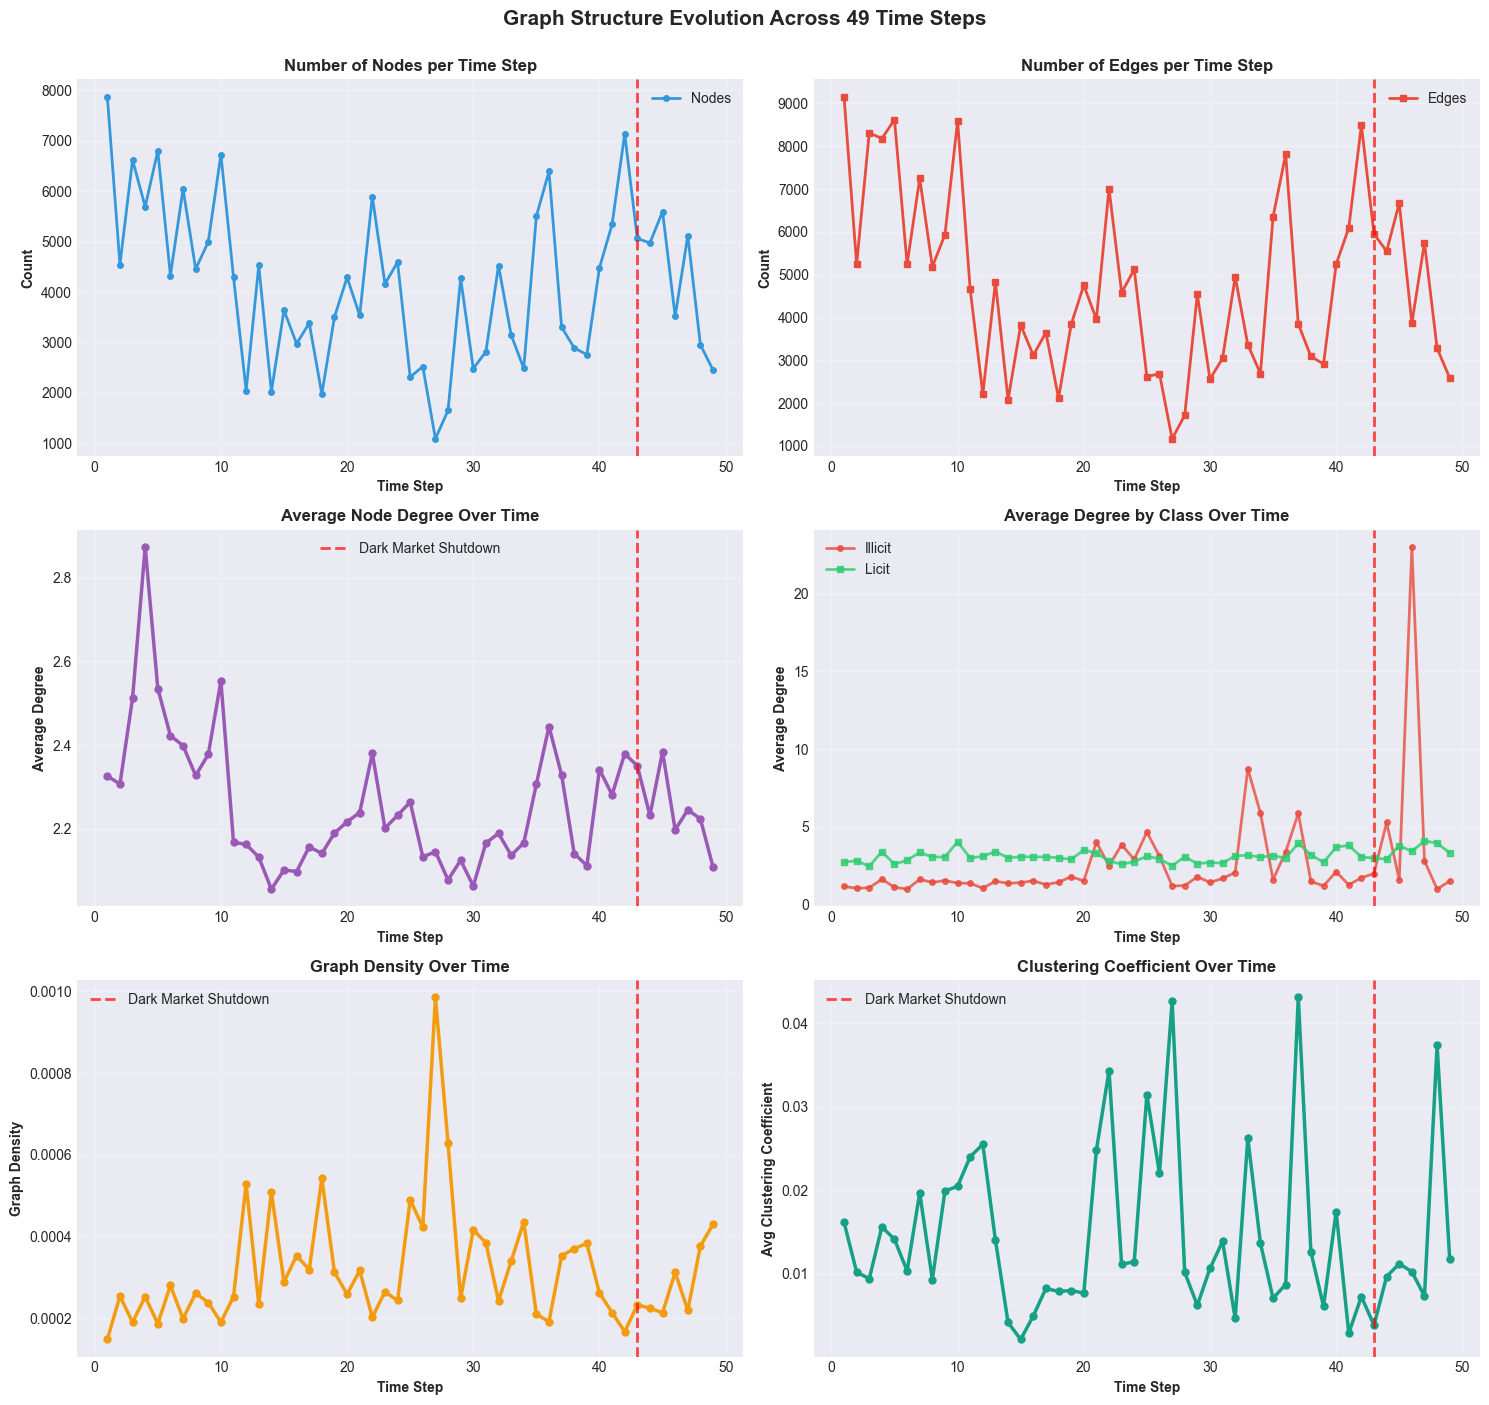

In [19]:
# Visualize graph metrics evolution
fig, axes = plt.subplots(3, 2, figsize=(15, 14))

# Plot 1: Number of nodes and edges
ax = axes[0, 0]
ax.plot(metrics_df['time_step'], metrics_df['num_nodes'], marker='o', 
        linewidth=2, markersize=4, label='Nodes', color='#3498db')
ax.axvline(x=43, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.set_xlabel('Time Step', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Number of Nodes per Time Step', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

ax2 = axes[0, 1]
ax2.plot(metrics_df['time_step'], metrics_df['num_edges'], marker='s', 
         linewidth=2, markersize=4, label='Edges', color='#e74c3c')
ax2.axvline(x=43, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_xlabel('Time Step', fontweight='bold')
ax2.set_ylabel('Count', fontweight='bold')
ax2.set_title('Number of Edges per Time Step', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 2: Average degree
ax = axes[1, 0]
ax.plot(metrics_df['time_step'], metrics_df['avg_degree'], marker='o', 
        linewidth=2.5, markersize=5, color='#9b59b6')
ax.axvline(x=43, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label='Dark Market Shutdown')
ax.set_xlabel('Time Step', fontweight='bold')
ax.set_ylabel('Average Degree', fontweight='bold')
ax.set_title('Average Node Degree Over Time', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Plot 3: Degree by class
ax = axes[1, 1]
ax.plot(metrics_df['time_step'], metrics_df['illicit_avg_degree'], marker='o', 
        linewidth=2, markersize=4, color='#e74c3c', label='Illicit', alpha=0.8)
ax.plot(metrics_df['time_step'], metrics_df['licit_avg_degree'], marker='s', 
        linewidth=2, markersize=4, color='#2ecc71', label='Licit', alpha=0.8)
ax.axvline(x=43, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.set_xlabel('Time Step', fontweight='bold')
ax.set_ylabel('Average Degree', fontweight='bold')
ax.set_title('Average Degree by Class Over Time', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Plot 4: Graph density
ax = axes[2, 0]
ax.plot(metrics_df['time_step'], metrics_df['density'], marker='o', 
        linewidth=2.5, markersize=5, color='#f39c12')
ax.axvline(x=43, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label='Dark Market Shutdown')
ax.set_xlabel('Time Step', fontweight='bold')
ax.set_ylabel('Graph Density', fontweight='bold')
ax.set_title('Graph Density Over Time', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Plot 5: Clustering coefficient
ax = axes[2, 1]
ax.plot(metrics_df['time_step'], metrics_df['avg_clustering'], marker='o', 
        linewidth=2.5, markersize=5, color='#16a085')
ax.axvline(x=43, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label='Dark Market Shutdown')
ax.set_xlabel('Time Step', fontweight='bold')
ax.set_ylabel('Avg Clustering Coefficient', fontweight='bold')
ax.set_title('Clustering Coefficient Over Time', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

fig.suptitle('Graph Structure Evolution Across 49 Time Steps', 
             fontweight='bold', fontsize=15, y=1.00)
plt.tight_layout()
plt.show()

In [20]:
# Identify structural inflection points
print("Structural Inflection Point Analysis:")
print("="*60)

# Calculate rate of change for key metrics
metrics_df['degree_change'] = metrics_df['avg_degree'].diff()
metrics_df['density_change'] = metrics_df['density'].diff()
metrics_df['clustering_change'] = metrics_df['avg_clustering'].diff()

# Find largest changes
print("\nLargest Changes in Average Degree:")
top_degree_changes = metrics_df.nlargest(5, 'degree_change', keep='all')[['time_step', 'avg_degree', 'degree_change']]
print(top_degree_changes.to_string(index=False))

print("\nLargest Changes in Graph Density:")
top_density_changes = metrics_df.nlargest(5, 'density_change', keep='all')[['time_step', 'density', 'density_change']]
print(top_density_changes.to_string(index=False))

print("="*60)

Structural Inflection Point Analysis:

Largest Changes in Average Degree:
 time_step  avg_degree  degree_change
         4    2.873705       0.361697
        40    2.341442       0.229847
         3    2.512007       0.205229
        10    2.553293       0.175791
        45    2.384066       0.152508

Largest Changes in Graph Density:
 time_step  density  density_change
        27 0.000986        0.000563
        12 0.000528        0.000276
        14 0.000509        0.000273
        25 0.000489        0.000246
        18 0.000542        0.000223


---
## Part 5: Time-Aware Feature Engineering

Create temporal features to improve model robustness.

In [21]:
# Create time-aware features
print("Engineering time-aware features...\n")

# 1. Time period categorical (early/mid/late)
df['time_period'] = pd.cut(df['time_step'], bins=[0, 16, 33, 49], 
                            labels=['early', 'mid', 'late'])

# 2. Time since beginning (normalized)
df['time_normalized'] = (df['time_step'] - 1) / 48

# 3. Pre/post dark market shutdown
df['post_shutdown'] = (df['time_step'] > 43).astype(int)

# 4. Rolling window statistics (3-step window)
for feat in ['feature_0', 'feature_1', 'feature_2']:  # Example features
    df[f'{feat}_rolling_mean'] = df.groupby('time_step')[feat].transform('mean')
    
print("New temporal features created:")
print("  - time_period (categorical: early/mid/late)")
print("  - time_normalized (0 to 1)")
print("  - post_shutdown (binary: 0/1)")
print("  - Rolling window means for sample features")

print(f"\nDataset shape with new features: {df.shape}")

Engineering time-aware features...

New temporal features created:
  - time_period (categorical: early/mid/late)
  - time_normalized (0 to 1)
  - post_shutdown (binary: 0/1)
  - Rolling window means for sample features

Dataset shape with new features: (203768, 174)


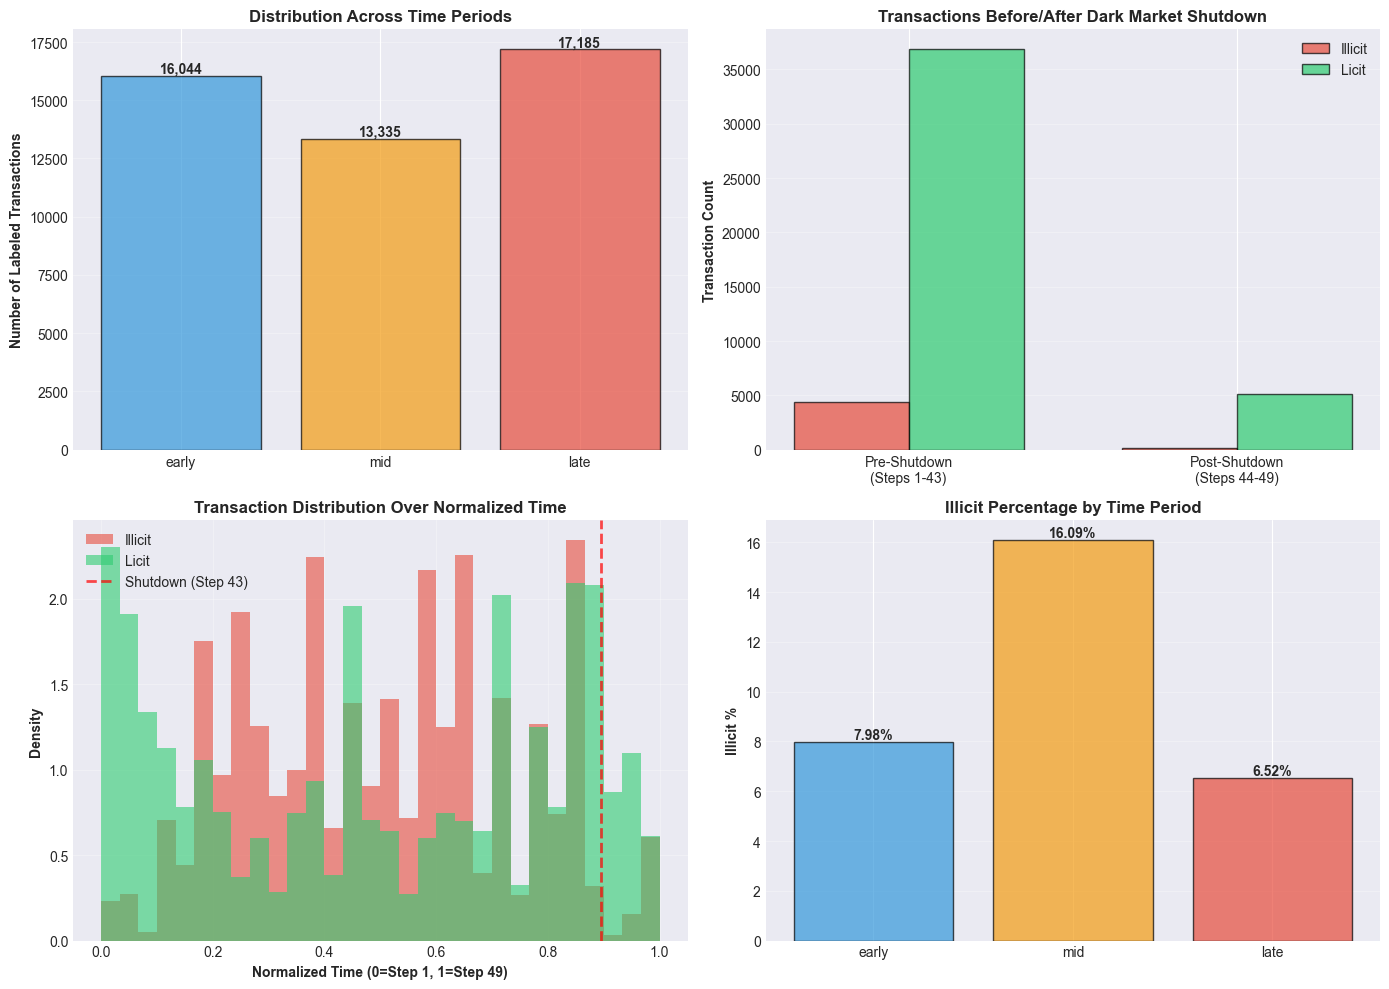

In [22]:
# Visualize temporal features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Time period distribution
ax = axes[0, 0]
period_counts = df[df['label'] != 'unknown']['time_period'].value_counts().sort_index()
bars = ax.bar(range(len(period_counts)), period_counts.values, 
              color=['#3498db', '#f39c12', '#e74c3c'], alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(period_counts)))
ax.set_xticklabels(period_counts.index)
ax.set_ylabel('Number of Labeled Transactions', fontweight='bold')
ax.set_title('Distribution Across Time Periods', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Pre/post shutdown comparison
ax = axes[0, 1]
shutdown_illicit = df[df['label'] == '1'].groupby('post_shutdown').size()
shutdown_licit = df[df['label'] == '2'].groupby('post_shutdown').size()

x = np.arange(2)
width = 0.35

ax.bar(x - width/2, shutdown_illicit.values, width, label='Illicit', 
       color='#e74c3c', alpha=0.7, edgecolor='black')
ax.bar(x + width/2, shutdown_licit.values, width, label='Licit', 
       color='#2ecc71', alpha=0.7, edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(['Pre-Shutdown\n(Steps 1-43)', 'Post-Shutdown\n(Steps 44-49)'])
ax.set_ylabel('Transaction Count', fontweight='bold')
ax.set_title('Transactions Before/After Dark Market Shutdown', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 3: Time normalized distribution
ax = axes[1, 0]
ax.hist(df[df['label'] == '1']['time_normalized'], bins=30, alpha=0.6, 
        color='#e74c3c', label='Illicit', density=True)
ax.hist(df[df['label'] == '2']['time_normalized'], bins=30, alpha=0.6, 
        color='#2ecc71', label='Licit', density=True)
ax.axvline(x=43/48, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label='Shutdown (Step 43)')
ax.set_xlabel('Normalized Time (0=Step 1, 1=Step 49)', fontweight='bold')
ax.set_ylabel('Density', fontweight='bold')
ax.set_title('Transaction Distribution Over Normalized Time', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Plot 4: Illicit percentage by time period
ax = axes[1, 1]
period_stats = df[df['label'] != 'unknown'].groupby('time_period').apply(
    lambda x: (x['label'] == '1').sum() / len(x) * 100
)

bars = ax.bar(range(len(period_stats)), period_stats.values, 
              color=['#3498db', '#f39c12', '#e74c3c'], alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(period_stats)))
ax.set_xticklabels(period_stats.index)
ax.set_ylabel('Illicit %', fontweight='bold')
ax.set_title('Illicit Percentage by Time Period', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, period_stats.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

---
## Summary & Key Findings

In [23]:
print("="*70)
print("TEMPORAL PATTERN ANALYSIS - SUMMARY")
print("="*70)

print("\n1. DARK MARKET SHUTDOWN EVENT (Time Step 43):")
print(f"   - Illicit transactions changed: {illicit_change:+.1f}%")
print(f"   - Licit transactions changed: {licit_change:+.1f}%")
print(f"   - Illicit % shifted: {pct_change:+.2f} percentage points")
if p_value < 0.05:
    print(f"   ✓ Statistically significant shift detected (p={p_value:.4f})")

print("\n2. FEATURE DISTRIBUTION DRIFT:")
print(f"   - Features with significant drift: {n_drifted}/166 ({n_drifted/166*100:.1f}%)")
drift_local = (significant_drift['Feature_Type'] == 'Local').sum()
drift_agg = (significant_drift['Feature_Type'] == 'Aggregated').sum()
print(f"   - Local features drifted: {drift_local}/94 ({drift_local/94*100:.1f}%)")
print(f"   - Aggregated features drifted: {drift_agg}/72 ({drift_agg/72*100:.1f}%)")
print(f"   - Mean JS divergence: {drift_df['JS_Divergence'].mean():.4f}")

print("\n3. FRAUD PATTERN EVOLUTION:")
avg_fraud_sim = np.nanmean(fraud_similarities)
avg_licit_sim = np.nanmean(licit_similarities)
print(f"   - Average fraud pattern similarity: {avg_fraud_sim:.4f}")
print(f"   - Average licit pattern similarity: {avg_licit_sim:.4f}")
print(f"   - Significant pattern changes detected: {len(fraud_changes)}")
if avg_fraud_sim < avg_licit_sim:
    print("   ⚠ Fraud patterns are LESS stable than licit patterns")
    print("     → This explains temporal split performance degradation")

print("\n4. GRAPH STRUCTURE EVOLUTION:")
avg_degree_before = metrics_df[metrics_df['time_step'] <= 43]['avg_degree'].mean()
avg_degree_after = metrics_df[metrics_df['time_step'] > 43]['avg_degree'].mean()
print(f"   - Avg degree before step 43: {avg_degree_before:.3f}")
print(f"   - Avg degree after step 43:  {avg_degree_after:.3f}")
print(f"   - Change: {(avg_degree_after - avg_degree_before)/avg_degree_before*100:+.1f}%")

print("\n5. TIME-AWARE FEATURES CREATED:")
print("   ✓ Time period (early/mid/late)")
print("   ✓ Normalized time (0-1)")
print("   ✓ Post-shutdown indicator")
print("   ✓ Rolling window statistics")

print("\n6. KEY INSIGHTS:")
print("   ⚠ Step 43 is a critical inflection point (dark market shutdown)")
print("   ⚠ Fraud patterns evolve faster than licit patterns")
print(f"   ⚠ {n_drifted/166*100:.0f}% of features show significant drift over time")
print("   → Temporal models MUST account for distribution shift")
print("   → Static models trained on early data will fail on late data")

print("\n7. RECOMMENDATIONS:")
print("   ✓ Use time-aware features in GCN models")
print("   ✓ Implement domain adaptation techniques")
print("   ✓ Consider ensemble of period-specific models")
print("   ✓ Regular model retraining (concept drift handling)")
print("   ✓ Focus on drift-resistant features for better generalization")

print("\n" + "="*70)

TEMPORAL PATTERN ANALYSIS - SUMMARY

1. DARK MARKET SHUTDOWN EVENT (Time Step 43):
   - Illicit transactions changed: -76.4%
   - Licit transactions changed: +0.6%
   - Illicit % shifted: -8.33 percentage points
   ✓ Statistically significant shift detected (p=0.0167)

2. FEATURE DISTRIBUTION DRIFT:
   - Features with significant drift: 160/166 (96.4%)
   - Local features drifted: 93/94 (98.9%)
   - Aggregated features drifted: 67/72 (93.1%)
   - Mean JS divergence: 0.1117

3. FRAUD PATTERN EVOLUTION:
   - Average fraud pattern similarity: 0.6747
   - Average licit pattern similarity: 0.7006
   - Significant pattern changes detected: 37
   ⚠ Fraud patterns are LESS stable than licit patterns
     → This explains temporal split performance degradation

4. GRAPH STRUCTURE EVOLUTION:
   - Avg degree before step 43: 2.262
   - Avg degree after step 43:  2.232
   - Change: -1.3%

5. TIME-AWARE FEATURES CREATED:
   ✓ Time period (early/mid/late)
   ✓ Normalized time (0-1)
   ✓ Post-shutdown 